# Compare Experimental Observables with Generated ones

```
# Copyright 2025 Peptone Ltd
#
# Licensed under the Apache License, Version 2.0 (the "License");
# you may not use this file except in compliance with the License.
# You may obtain a copy of the License at
#
#      http://www.apache.org/licenses/LICENSE-2.0
#
# Unless required by applicable law or agreed to in writing, software
# distributed under the License is distributed on an "AS IS" BASIS,
# WITHOUT WARRANTIES OR CONDITIONS OF ANY KIND, either express or implied.
# See the License for the specific language governing permissions and
# limitations under the License.
```

In [ ]:
import json
import os.path

import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
from tqdm import tqdm
import mdtraj as md
import nglview as nv

In [2]:
SMALL_SIZE = 12
MEDIUM_SIZE = 14
BIG_SIZE = 16

plt.rc("font", size=SMALL_SIZE)
plt.rc("axes", titlesize=SMALL_SIZE)
plt.rc("axes", labelsize=MEDIUM_SIZE)
plt.rc("xtick", labelsize=SMALL_SIZE)
plt.rc("ytick", labelsize=SMALL_SIZE)
plt.rc("legend", fontsize=SMALL_SIZE)
plt.rc("figure", titlesize=BIG_SIZE)

g_name = {
    "alphafold": "AlphaFold2",
    "bioemu": "BioEmu",
    "boltz1x": "Boltz1x",
    "boltz2": "Boltz2",
    "esmflow": "ESMFlow",
    "esmfold": "ESMFold",
    "idp-o": "IDP-o",
    "idpfold": "IDPFold",
    "idpgan": "idpGAN",
    "idpsam": "idpSAM",
    "peptron_stable_pdb_20250809_236800": "PepTron-base",
    "peptron_stable_pdb_idrome_20250812_256000": "PepTron",
    "random_coil": "Random Coil",
}

In [3]:
from peptonebench import nmrcs, saxs, reweighting, plotting
from peptonebench.config import DB_CS, DB_SAXS

pep_cs_df = pd.read_csv(
    DB_CS,
    index_col="label",
    converters={"gscores": lambda s: np.asarray(json.loads(s), dtype=float)},
)
pep_saxs_df = pd.read_csv(DB_SAXS, index_col="label")

Ordered residues: [ 66  67  68  69  70  71  72  73  74  75  76  77  78  79  80  81  82  83
  84  85  86  87  88  89  90  91  92  93  94  95  96  97  98  99 100 101
 102 103 104 105 106 107 108 109 110 111 112 113 114 115 116 117 118 119
 120 121]
Longest contiguous segment: [ 66  67  68  69  70  71  72  73  74  75  76  77  78  79  80  81  82  83
  84  85  86  87  88  89  90  91  92  93  94  95  96  97  98  99 100 101
 102 103 104 105 106 107 108 109 110 111 112 113 114 115 116 117 118 119
 120 121]


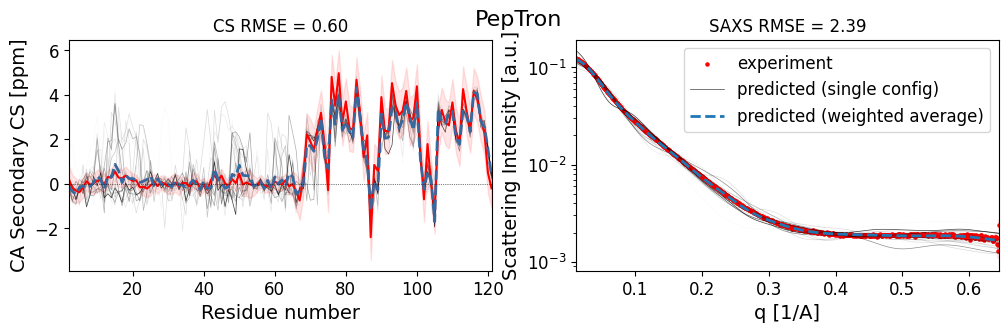

NGLWidget()

In [ ]:
base_path = "../datasets"
generator = "peptron_stable_pdb_idrome_20250812_256000"

protein = "MenVp"
label_cs = "27634_1_1_1"
label_saxs = "SASDLH9"

save_fig = False
s = 1.0  # scaling factor for the figure size
sc_lw = 0.5
sc_alpha = 0.75

chosen_rmse = "rew_RMSE"
cs_type = "CA"
predictor_cs = "UCBshift"
tag_cs = f"{predictor_cs}-{cs_type}"
tag_saxs = "Pepsi"

res, uncertainties, exp_cs, gen_cs = nmrcs.get_all_about_secondary_cs_from_label(
    label_cs,
    cs_type,
    generator_dir=f"{base_path}/{generator}",
    predictor=predictor_cs,
    gen_filename=f"PREDICTOR-{protein}.csv",
)

info_cs = pd.read_csv(f"{base_path}/{generator}/rew_info-{tag_cs}.csv", index_col="label")
if chosen_rmse == "rew_RMSE":
    weights = pd.read_csv(f"{base_path}/{generator}/rew_weights-{tag_cs}.csv")[protein].to_numpy()
    # weights = pd.read_csv(f"{base_path}/{generator}/rew_weights-{tag_saxs}.csv")[protein].to_numpy()
elif chosen_rmse == "RMSE":
    weights = np.ones(gen_cs.shape[1]) / gen_cs.shape[1]
else:
    raise ValueError(f"Unknown chosen_rmse: {chosen_rmse}")
nan_mask = np.isfinite(weights)
weights, gen_cs = weights[nan_mask], gen_cs[:, nan_mask]
plt.figure(figsize=(12 / s, 3 / s))
plt.subplot(1, 2, 1)
# plt.suptitle(f"{g_name[generator.split('/')[0]]} - {label}")
plt.suptitle(f"{g_name[generator.split('/')[0]]}")
if chosen_rmse == "rew_RMSE":
    for i in range(len(weights)):
        plt.plot(res, gen_cs[:, i], alpha=sc_alpha * weights[i] / weights.max(), lw=sc_lw, c="k")
plt.plot(res, exp_cs, c="r")
plt.fill_between(res, exp_cs - uncertainties, exp_cs + uncertainties, alpha=0.1, color="r", zorder=1e5)
plt.plot((np.nan, np.nan), c="k", lw=sc_lw, alpha=sc_alpha)
plt.plot(res, np.average(gen_cs, axis=1, weights=weights), ls="--", lw=2)
plt.axhline(0, c="k", lw=0.5, ls=":")
plt.margins(x=0)
plt.xlabel("Residue number")
plt.ylabel(f"{cs_type} Secondary CS [ppm]")
plt.title(f"CS RMSE = {info_cs.loc[protein, chosen_rmse]:.2f}")
plt.subplot(1, 2, 2)

trj_filename, top_filename = reweighting.get_ens_top_filenames(f"{base_path}/{generator}/{protein}")
trj = md.load(trj_filename, top=top_filename)[nan_mask][np.argsort(-weights)]
residue_indexes = np.where(pep_cs_df.loc[label_cs, "gscores"] < 0.5)[0] + 1
if len(residue_indexes) == 0:
    print("No ordered residues, alligning with all")
    atom_indices = None
else:
    print(f"Ordered residues: {residue_indexes}")
    contiguous_segments = np.split(residue_indexes, np.where(np.diff(residue_indexes) != 1)[0] + 1)
    longest_segment = max(contiguous_segments, key=len)
    print(f"Longest contiguous segment: {longest_segment}")
    if len(longest_segment) < 5:
        print("Longest contiguous segment too short, alligning with all residues")
        atom_indices = None
    else:
        atom_indices = [a.index for a in trj.topology.atoms if a.residue.index in longest_segment]
trj.superpose(trj, atom_indices=atom_indices)

info_saxs = pd.read_csv(f"{base_path}/{generator}/rew_info-{tag_saxs}.csv", index_col="label")
# expt_df = saxs.get_exp_df_from_label(label_saxs)
expt_df = saxs.parse_sasbdb_dat(f"{base_path}/{protein}-SAXS_bift.dat")  # more q values, looks nicer
gen_df = pd.read_csv(f"{base_path}/{generator}/Pepsi-{protein}.csv", index_col=0)
if chosen_rmse == "rew_RMSE":
    weights = pd.read_csv(f"{base_path}/{generator}/rew_weights-{tag_saxs}.csv")[protein].to_numpy()
else:
    weights = np.ones(len(gen_df)) / len(gen_df)
nan_mask = np.isfinite(weights)
weights, gen_df = weights[nan_mask], gen_df[nan_mask]
# gen_df = gen_df[nan_mask]

plt.title(f"SAXS RMSE = {info_saxs.loc[protein, chosen_rmse]:.2f}")
# plt.title(f"SAXS RMSE = {reweighting.get_RMSE(gen_df / expt_df['sigma'].to_numpy()[None, :], expt_df['I(q)'] / expt_df['sigma'], weights):.2f}")
plt.errorbar(expt_df["q"], expt_df["I(q)"], yerr=expt_df["sigma"], ls="", alpha=0.1, c="r")
plt.scatter(expt_df["q"], expt_df["I(q)"], s=5, color="r", label="experiment")
if chosen_rmse == "rew_RMSE":
    for i in range(len(gen_df)):
        plt.plot(
            gen_df.columns.astype(float), gen_df.iloc[i], alpha=sc_alpha * weights[i] / weights.max(), lw=sc_lw, c="k"
        )
if len(gen_df) > 1:
    plt.plot((np.nan, np.nan), label="predicted (single config)", c="k", lw=sc_lw, alpha=sc_alpha)
    label_gen = "predicted (weighted average)"
else:
    label_gen = "predicted (single config)"
plt.plot(expt_df["q"], np.average(gen_df.to_numpy(), weights=weights, axis=0), ls="--", lw=2, label=label_gen)
plt.yscale("log")
plt.ylabel("Scattering Intensity [a.u.]")
plt.xlabel("q [1/A]")
plt.margins(x=0)
plt.legend()
if save_fig:
    plt.savefig(f"{protein}-{g_name[generator.split('/')[0]]}-cs_saxs.png", dpi=300, bbox_inches="tight")
plt.show()


representation = "cartoon"
color_scheme = plotting.nv_custom_coloring(pep_cs_df.loc[label_cs, "gscores"], topology=trj.top)
view = nv.show_mdtraj(trj[0], default_representation=False)
view.add_representation(representation, color_scheme=color_scheme)
for i in range(1, min(10, len(trj))):
    view.add_trajectory(trj[i], default_representation=False)
    view[-1].add_representation(representation, color_scheme=color_scheme, opacity=0.2)
view

In [ ]:
# view.download_image(f"{protein}-{g_name[generator]}.png", factor=10, trim=True)